In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn import metrics
import pdb
# mpl.rcParams['figure.figsize'] = (15,15)

mpl.rcParams['figure.figsize'] = (9,7)

plt.ioff()

color = ["g", 'b','r','grey', 'black','teal','cornflowerblue', 'g', 'gray', 'c', 'r','m', 'y', 'k']
label_font_size = 18
#marker = ['>', 'v', '^', 'o', 's']
marker = ["x","*","v","o","s",">","^"]

d = 'out/'
def getXY(file_name, n = 3000):
    x, y = [], []
    with open(file_name) as f:
        for i, line in enumerate(f):
            entries = line.split()
            y.append(float(entries[0]))
            x.append(float(entries[1]))
            if i >= n:
                break
    return x, y

def plot_mul(files,name="image.pdf",legend=None):
    '''
    Plot P-R curves of muliple models.
    '''
    print(d)
    for i, f in enumerate(files):
        path = './{}/{}'.format(d,f)
        if not os.path.exists(path):
            print('{} is not exists'.format(f))
            continue

        x, y = getXY(path)
        plt.plot(x,y, marker = marker[i%len(marker)], markevery = 100, markersize = 10, color = color[i%len(color)])
    # legend = ['_'.join(i.split('_')[:-2]) for i in files]
    if legend is None:
        legend = ['_'.join(i.split('_')[:-3]) for i in files]
    
    plt.legend(legend, prop={'size':18})
    plt.ylim([0.3, 1])
    # plt.xlim([0.0, 0.5])
    plt.xlim([0.0, 0.4])
    plt.xlabel('Recall', fontsize=label_font_size)
    plt.ylabel('Precision', fontsize=label_font_size)
    plt.gca().tick_params(labelsize=16)
    plt.grid(linestyle='dashdot')
    # plt.savefig(name, bbox_inches='tight')
    plt.savefig(name)

    plt.show()    
    

def plot_one(prefix, flag=True):
    '''
    Plot multiple curves of one model.
    Using model prefix, (e.g. PCNN_ATT_DEF)
    '''
    fid = []
    print(d)
    for i in range(1, 25):
        if flag:
            path = './{}/{}_{}_PR.txt'.format(d, prefix, i)
        else:
            path = './{}/{}_{}.txt'.format(d, prefix, i)
        if not os.path.exists(path):
            #print path
            continue
        fid.append(i)
        x, y = getXY(path)
        plt.plot(x,y, marker = '>', markevery = 100, markersize = 5, color = color[(i-1)%len(color)])
        
    plt.legend([prefix + str(i) for i in fid],prop={'size':10})
    plt.ylim([0.3, 1])
    plt.xlim([0.0, 0.5])
    plt.xlabel('Recall', fontsize=label_font_size,)
    plt.ylabel('Precision', fontsize=label_font_size)
    plt.gca().tick_params(labelsize=16)
    plt.grid(linestyle='dashdot')
    plt.show()

def get_pr_curve(files):
    # We need to get from this function:
    # 1. Precision under recall 0.1 0.2 0.3 0.4
    # 2. AUC of the P-R curve, stop by 0.4 recall
    # 3. P@N: 100, 200, 300, mean of the former three.

    # setups
    recall_thres = [0.1,0.2,0.3]
    auc_stop_recall = 0.3
    top_at_N = [100, 200, 300]

    p_at_n_all_list = []
    p_r_thres_all_list = []
    auc_list = []

    print(d)
    for i, f in enumerate(files):
        path = './{}/{}'.format(d,f)
        # print(path)
        if not os.path.exists(path):
            print('{} is not exists'.format(f))
            continue

        recall, precision = getXY(path)
        recall = np.array(recall)
        precision = np.array(precision)
        sort_p = precision[np.argsort(-precision)]
        sort_r = recall[np.argsort(-recall)]

        # p @ N
        p_at_n_list = sort_p[top_at_N].tolist()
        p_at_n_list.append(np.mean(p_at_n_list))

        p_at_n_all_list.append(p_at_n_list)

        # precision under recall
        p_r_thres_list = []
        for thres in recall_thres:
            nearest_idx = np.argmin(abs(recall-thres))
            p_r_thres_list.append(precision[nearest_idx].tolist())

        # auc stop by recall == 0.4
        stop_by_idx = np.argmin(abs(recall-auc_stop_recall))
        auc_list.append(metrics.auc(recall[:stop_by_idx], precision[:stop_by_idx]))

        p_r_thres_list.append(auc_list[-1])
        # auc_list.append(metrics.auc(recall, precision))

        p_r_thres_all_list.append(p_r_thres_list)

    # p @ N
    p_at_n_col = [str(x) for x in top_at_N] + ["mean"]
    df_pn = pd.DataFrame(p_at_n_all_list, index=files, columns=p_at_n_col)
    df_pn.to_csv("p_at_n.csv")
    print("***"*10+"[P@N]"+"***"*10)
    print(df_pn)

    # p r thres
    p_r_thres_col = [str(x) for x in recall_thres] + ["auc"]
    df_p_r_thres = pd.DataFrame(p_r_thres_all_list, index=files, columns=p_r_thres_col)
    df_p_r_thres.to_csv("p_r_thres.csv")
    print("***"*10+"[P-R]"+"***"*10)
    print(df_p_r_thres)


# NYT

out/


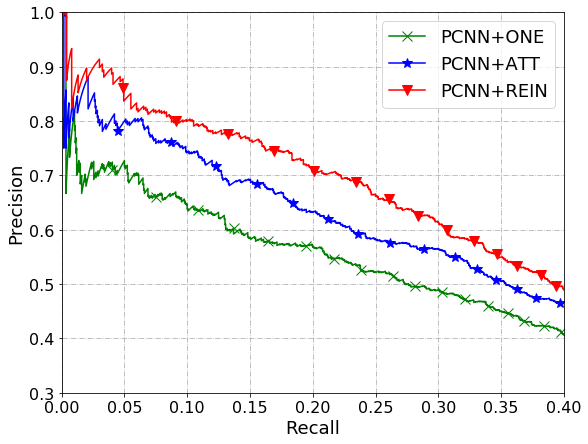

In [8]:
plot_mul(["NYT/PCNN_ONE_15_PR.txt","NYT/PCNN_ATT_10_PR.txt","NYT/PCNN_PIF_11_PR.txt",],"demo/nyt_PR.pdf",["PCNN+ONE","PCNN+ATT","PCNN+REIN"])

out/


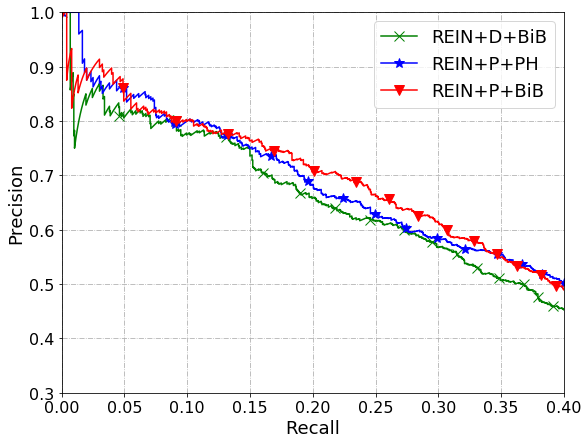

In [20]:
plot_mul(["NYT/PCNN_DIF_9_PR.txt","NYT/PCNN_IF_posthoc_7_PR.txt","NYT/PCNN_PIF_11_PR.txt",],"demo/nyt_REIN.pdf",["REIN+D+BiB","REIN+P+PH","REIN+P+BiB"])

In [9]:
get_pr_curve(["NYT/PCNN_ONE_15_PR.txt","NYT/PCNN_ATT_10_PR.txt","NYT/PCNN_PIF_11_PR.txt",])

out/
******************************[P@N]******************************
                             100       200       300      mean
NYT/PCNN_ONE_15_PR.txt  0.704225  0.663830  0.636364  0.668140
NYT/PCNN_ATT_10_PR.txt  0.797101  0.759563  0.716216  0.757627
NYT/PCNN_PIF_11_PR.txt  0.850000  0.801762  0.776667  0.809476
******************************[P-R]******************************
                             0.1       0.2       0.3       auc
NYT/PCNN_ONE_15_PR.txt  0.647059  0.571429  0.488889  0.182156
NYT/PCNN_ATT_10_PR.txt  0.742616  0.633094  0.564706  0.206327
NYT/PCNN_PIF_11_PR.txt  0.800000  0.706827  0.614668  0.227819


# FilterNYT

out/


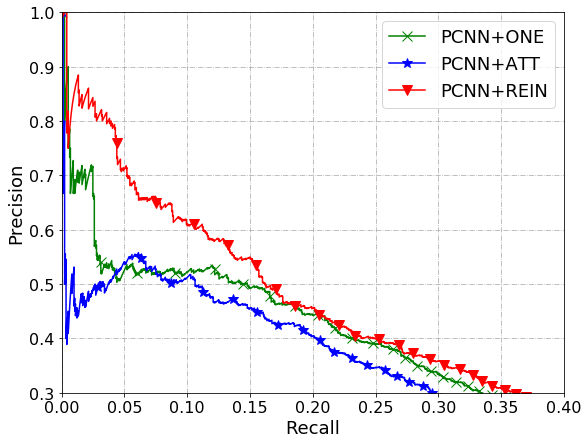

In [14]:
plot_mul(["FilterNYT/PCNN_ONE_6_PR.txt","FilterNYT/PCNN_ATT_6_PR.txt","FilterNYT/PCNN_PIF_8_PR.txt",],"demo/filternyt_PR.pdf",["PCNN+ONE","PCNN+ATT","PCNN+REIN"])

out/


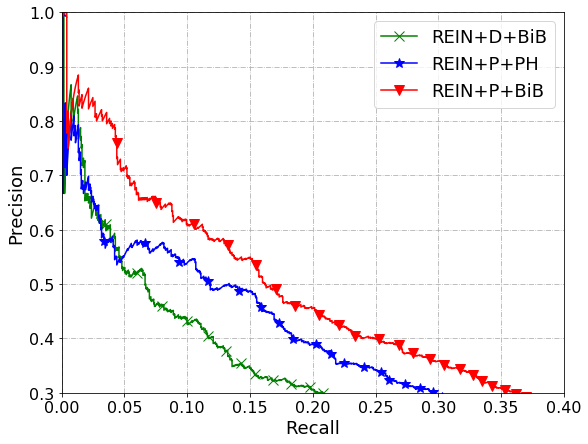

In [22]:
plot_mul(["FilterNYT/PCNN_DIF_9_PR.txt","FilterNYT/PCNN_IF_posthoc_6_PR.txt","FilterNYT/PCNN_PIF_8_PR.txt"], "demo/filternyt_REIN.pdf",["REIN+D+BiB","REIN+P+PH","REIN+P+BiB"])

In [13]:
get_pr_curve(["FilterNYT/PCNN_ONE_6_PR.txt","FilterNYT/PCNN_ATT_6_PR.txt","FilterNYT/PCNN_PIF_8_PR.txt",])

out/
******************************[P@N]******************************
                                  100       200       300      mean
FilterNYT/PCNN_ONE_6_PR.txt  0.540000  0.526596  0.521912  0.529503
FilterNYT/PCNN_ATT_6_PR.txt  0.526531  0.507042  0.494764  0.509446
FilterNYT/PCNN_PIF_8_PR.txt  0.752475  0.650718  0.608247  0.670480
******************************[P-R]******************************
                                  0.1       0.2       0.3       auc
FilterNYT/PCNN_ONE_6_PR.txt  0.522659  0.444730  0.334620  0.146138
FilterNYT/PCNN_ATT_6_PR.txt  0.511834  0.404206  0.296465  0.130965
FilterNYT/PCNN_PIF_8_PR.txt  0.611307  0.455263  0.358374  0.166606


##### 